# LCK 2024 exploratory data analysis

## I. Adding relevant imports and reading the data

In [96]:
# Relevant imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_excel('lck-players-2024-spring-split.xlsx', sheet_name='Match List Spring 2024')
df.head()

,Player,Champion,Result,Score,Duration,Date,Game,Tournament,ID Player
0,Aiming,Jinx,Defeat,1/4/4,33:19,45374,HLE vs Dplus KIA,LCK Spring 2024,1
1,Aiming,Aphelios,Defeat,1/3/5,32:35,45374,HLE vs Dplus KIA,LCK Spring 2024,1
2,Aiming,Kalista,Defeat,0/1/0,34:55,45372,Dplus KIA vs KDF,LCK Spring 2024,1
3,Aiming,Kalista,Defeat,9/4/4,36:39,45372,Dplus KIA vs KDF,LCK Spring 2024,1
4,Aiming,Xayah,Defeat,1/2/10,42:38,45368,Dplus KIA vs GEN,LCK Spring 2024,1


As shown above, the given data contains 9 columns which contains the following information:

| Column    | Info |
| -------- | ------- |
| Player  | Player name    |
| Champion | Champion used by the player for that game     |
| Result    | Game result. Contains either "Victory" or "Defeat"    |
| Score | Contains the Kill/Death/Assist score of the player for that game |
| Duration| Contains the length of the game in string format |
| Date | Supposedly contains the date from which the game was played. Appears to be in key format |
| Game | Game title. Not used because teams having rematch may cause redundance |
| Tournament | Tournament name |
|ID Player | Contains player id |

## II. Cleaning the data

Started by counting the number of missing values from the data

In [97]:
print(f"Number of missing values: {df.isna().sum().sum()}")

Number of missing values: 0


Next, we drop columns that will not be used for this analysis. In this case, we have three columns

| Dropped Column    | Reason |
| -------- | ------- |
| Date | Supposedly contains the date from which the game was played. Appears to be in key format |
| Game | Teams having rematch may cause redundance |
| Tournament | Only has one value throughout the tournament |
|ID Player | Redundant with the "Player" column |

In [98]:
df=df.drop(['Date', 'Game','Tournament','ID Player'], axis=1)
df.sample(n=5)

,Player,Champion,Result,Score,Duration
372,Clear,Rumble,Victory,4/0/8,32:20
1559,Pleata,Nautilus,Defeat,1/6/3,29:42
1438,PerfecT,KSante,Victory,4/1/7,26:31
625,Doran,KSante,Victory,1/3/9,33:19
1107,Keria,Nami,Defeat,0/2/5,31:26


Next, we convert the Score column into three numerical columns: "Kills", "Deaths", and "Assists"

In [99]:
df[['Kills','Deaths','Assists']] = df['Score'].str.split(pat='/',n=2, expand=True)
df[['Kills','Deaths','Assists']]=df[['Kills','Deaths','Assists']].astype('int')
df=df.drop('Score', axis=1)
df.sample(n=5)

,Player,Champion,Result,Duration,Kills,Deaths,Assists
360,Chovy,Yone,Victory,42:51,7,2,9
2039,Zeus,Gnar,Victory,28:42,3,1,10
1970,Willer,Sejuani,Victory,42:16,1,1,10
1148,Kiin,KSante,Victory,26:55,3,0,7
1046,Karis,Tristana,Defeat,31:37,1,1,2


We then converted the "Duration" column into seconds

In [100]:
df[['Minutes','Seconds']] = df['Duration'].str.split(pat=':',n=1,expand=True)
df['Game_length_secs'] = df['Seconds'].astype('int')+60*df['Minutes'].astype('int')
df = df.drop(['Minutes','Seconds'],axis=1)
df.sample(n=5)

,Player,Champion,Result,Duration,Kills,Deaths,Assists,Game_length_secs
94,Bdd,Taliyah,Victory,31:16,9,2,7,1876
1066,Kellin,Tahm Kench,Victory,28:53,0,1,10,1733
732,Envyy,Varus,Defeat,26:29,2,4,4,1589
1687,Samver,Caitlyn,Defeat,32:07,3,2,1,1927
534,Deft,Senna,Victory,40:28,8,2,13,2428


KDA ratio is often used as a metric of performance of a player in the game. We also added it here

In [101]:
df['KDA_ratio']=(df['Kills']+df['Assists'])/df['Deaths']
df['Game_length_category']=np.where(df['Game_length_secs'] >= 30*60, 'late','early' )

## III. Agregating Data
In this section, statistics for grouped data were computed. Specifically,
1. Player data
2. Champion data

### Player related statistics
For player-related data, the following were computed:
1. Total number of wins
2. Total number of games
3. Average kills, deaths, and assists
4. Most frequently used champion
5. Average game length
6. Win rate
7. Tournament KDA Ratio

In [102]:
# Getting the number of wins
wins=pd.NamedAgg(column='Result', aggfunc=lambda x: (x == 'Victory').sum())
# Getting the number of games
total_games = pd.NamedAgg(column='Result', aggfunc='count') 
# Getting the kda ratio
Avg_Kills = pd.NamedAgg(column='Kills', aggfunc='mean')
Avg_Deaths = pd.NamedAgg(column='Deaths', aggfunc='mean')  
Avg_Assists = pd.NamedAgg(column='Assists', aggfunc='mean')
# Getting the most used champion
MostFrequentChampion=pd.NamedAgg(
        column='Champion', 
        aggfunc=lambda x: x.mode()[0] if not x.mode().empty else None
    )
# Getting the average game length
avg_game_length = pd.NamedAgg(column='Game_length_secs', aggfunc='mean')
                    
player_data = df.groupby('Player', as_index=False).agg(
    total_games=total_games, 
    wins=wins,
    Most_used_champion=MostFrequentChampion,
    avg_game_length = avg_game_length,
    Avg_Kills=Avg_Kills,
    Avg_Deaths=Avg_Deaths,
    Avg_Assists = Avg_Assists)
player_data['win_rate'] = player_data['wins']/player_data['total_games']*100
player_data['KDA_ratio'] = (player_data['Avg_Kills']+player_data['Avg_Assists'])/player_data['Avg_Deaths']
player_data=np.round(player_data,2)
player_data=player_data.sort_values('KDA_ratio', ascending=False).reset_index(drop=True)
player_data.head(12)

,Player,total_games,wins,Most_used_champion,avg_game_length,Avg_Kills,Avg_Deaths,Avg_Assists,win_rate,KDA_ratio
0,Viper,41,30,Varus,1878.44,4.73,1.34,5.90,73.17,7.93
1,Peyz,39,34,Aphelios,1855.33,5.18,1.41,5.85,87.18,7.82
2,Guwon,2,2,Vi,1833.00,4.50,2.00,11.00,100.00,7.75
3,Delight,41,30,Rakan,1878.44,0.66,1.63,10.51,73.17,6.84
4,Canyon,39,34,Rell,1855.33,1.72,1.62,9.10,87.18,6.70
5,Chovy,39,34,Azir,1855.33,4.54,1.62,5.77,87.18,6.38
6,Zeka,41,30,Azir,1878.44,4.51,1.61,5.61,73.17,6.29
7,Keria,40,32,Nami,1837.88,1.75,1.85,9.32,80.00,5.99
8,Lehends,39,34,Milio,1855.33,0.74,1.82,9.79,87.18,5.79
9,Peanut,41,30,Maokai,1878.44,1.95,1.80,8.37,73.17,5.72


### Champion related statistics
For Champion-related data, the following were computed:
1. Total number of wins
2. Total number of games
3. Most frequently user
4. Win rate

In [103]:
# Getting the number of wins
wins=pd.NamedAgg(column='Result', aggfunc=lambda x: (x == 'Victory').sum())
# Getting the number of games
total_games = pd.NamedAgg(column='Result', aggfunc='count')  

## Most used by
MostFrequentUser=pd.NamedAgg(
        column='Player', 
        aggfunc=lambda x: x.mode()[0] if not x.mode().empty else None
    )
Championdata = df.groupby('Champion', as_index=False).agg(wins = wins, total_games=total_games,Most_Frequent_User=MostFrequentUser)
Championdata['win_rate']=Championdata['wins']/Championdata['total_games']*100

early_df=df[df['Game_length_category']=='early']
early_Championdata = early_df.groupby('Champion', as_index=False).agg(wins = wins, total_games=total_games)
early_Championdata['Early_win_rate'] = early_Championdata['wins']/early_Championdata['total_games']*100
early_Championdata = early_Championdata[['Champion','Early_win_rate']]

late_df=df[df['Game_length_category']=='late']
late_Championdata = late_df.groupby('Champion', as_index=False).agg(wins = wins, total_games=total_games)
late_Championdata['late_win_rate'] = late_Championdata['wins']/late_Championdata['total_games']*100
late_Championdata = late_Championdata[['Champion','late_win_rate']]
# Join the three dataframes

Championdata=pd.merge(Championdata, early_Championdata, on = 'Champion', how='inner',validate='1:1')
Championdata=pd.merge(Championdata, late_Championdata, on = 'Champion', how='inner',validate='1:1')

Championdata=np.round(Championdata,2)
# 
Championdata_relevant=Championdata[Championdata['total_games']>=10].reset_index(drop=True)
Championdata_relevant['diff']=np.abs(Championdata_relevant['late_win_rate']-Championdata_relevant['Early_win_rate'])
#print(Championdata_relevant.iloc[Championdata_relevant['diff'].idxmax()])
Championdata[['Champion','wins','win_rate','total_games','Most_Frequent_User']].sort_values('total_games', ascending=False).reset_index(drop=True).head(12)

,Champion,wins,win_rate,total_games,Most_Frequent_User
0,KSante,58,60.42,96,PerfecT
1,Aatrox,44,51.76,85,DuDu
2,Azir,37,43.53,85,Karis
3,Rell,40,57.97,69,Canyon
4,Varus,34,50.00,68,Hena
5,Taliyah,39,59.09,66,Bdd
6,Lucian,33,52.38,63,Aiming
7,Lee Sin,29,46.77,62,Cuzz
8,Nautilus,30,48.39,62,BeryL
9,Maokai,32,54.24,59,Peanut


## IV. Visualizations
The first visualization shows the number of games played by the top 20 players in terms of win rate

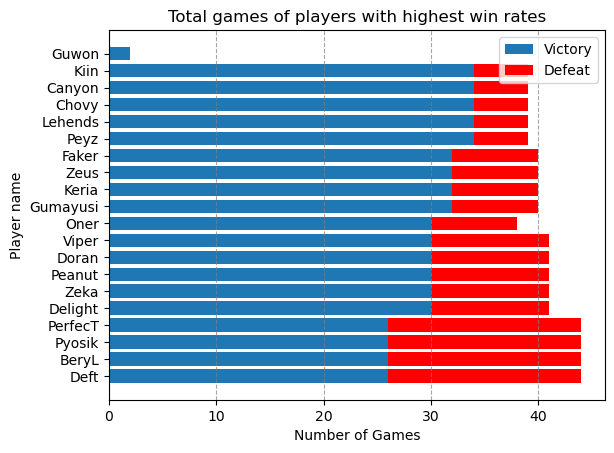

In [104]:
num = 20
fig1_data=player_data.sort_values('win_rate', ascending=False).reset_index(drop=True).head(num)
fig1_data=fig1_data.sort_values('win_rate', ascending=True).reset_index(drop=True)
fig1, ax1 = plt.subplots()
ax1.grid(axis='x', linestyle='--', color='gray', alpha=0.7)
ax1.barh(fig1_data['Player'],fig1_data['wins'], label='Victory')
ax1.barh(fig1_data['Player'], fig1_data['total_games']-fig1_data['wins'], left=fig1_data['wins'], color='red', label='Defeat')
ax1.legend()

ax1.set_xlabel('Number of Games')
ax1.set_ylabel('Player name')
ax1.set_title('Total games of players with highest win rates')
#ax1.invert_yticks()
#ax1.set_xticklabels(fig1_data['Player'],rotation=60)
plt.show()

Here, we can see that Guwon has the highest win rate(100%). However, he only played for a total of two games. With 0 losses and 100% win rate, it is safe to assume that Guwon is a substitute player, which he is. For second place, we have Kiin, Canyon, Chovy, Lehends, and Peyz, with a win rate of 87.18% comprised of 34 wins out of 39 games. They are the players who make up the roster of Gen.G. For third place, we have the Faker, Zeus, Keria, and Gumayusi, who makes up the roster of T1 with a win rate of 80%. We also have their teamate, Oner, slightly below with a win rate of 78.95%. Oner is slightly behind because he was substituted by Guwon for two games against OK Brion. With a win rate of 73.17%, next are the players of the Hanwa Life Esports roster: Viper, Doran, Peanut, Zeka, and Delight. The last four shown are players from KT Rolster: Perfert, Pyosik, Beryl, and Deft.

## KDA distributions of players with highest average kda

In [105]:
num=10
df_KDA_distrib=df[['Player', 'Kills', 'Deaths','Assists']]
df_KDA_distrib['KDA'] = (df_KDA_distrib['Kills']+df_KDA_distrib['Assists'])/df_KDA_distrib['Deaths']
KDA_grouped=df_KDA_distrib.groupby('Player', as_index=False)[['Kills', 'Deaths','Assists']].sum()
KDA_grouped['Tournament_KDA']=(KDA_grouped['Kills']+KDA_grouped['Assists'])/KDA_grouped['Deaths']
KDA_grouped['Tournament_KDA']=np.round(KDA_grouped['Tournament_KDA'],2)
KDA_grouped = KDA_grouped.sort_values('Tournament_KDA', ascending=False).reset_index(drop=True)

top_players_kda=list(KDA_grouped['Player'].head(num))
#print(top_players_kda)

# Subset ungrouped data to only include top players
subsetted_KDA = df_KDA_distrib[df_KDA_distrib['Player'].isin(top_players_kda)]
subsetted_KDA=subsetted_KDA.reset_index(drop=True)

#Creating the boxplot
g = sns.catplot(x='Player', y='KDA ratio',data=subsetted_KDA, kind='box', order=top_players_kda, whis=1.5)

# Customize the plot
#g.set_titles("Meow")
g.set_axis_labels("Player", "KDA")
g.fig.suptitle("KDA Distribution of Players with\n  highest tournament KDA(Left to Right)", y=1.05)
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.yticks(np.linspace(0,20,11))
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_1608\286875158.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_KDA_distrib['KDA'] = (df_KDA_distrib['Kills']+df_KDA_distrib['Assists'])/df_KDA_distrib['Deaths']


ValueError: Could not interpret value `KDA ratio` for `y`. An entry with this name does not appear in `data`.

Next, the top players with highest KDA ratios were identified. The top 10 players are shown above from left(highest KDA) to right(lowest KDA). Box plots were then plotted in order to show the distributions of their KDA for different games. Since Guwon only played two games, the plot only showed the KDA for the two games and their mean as the median. Although being the player with the highest KDA ratio, Viper's median is shown to be lower than the rest(except Guwon). However, the distance between his median and 75th percentile values indicate that his performance varies by a lot. Meanwhile, Lehends appear to be very consistent having 50% of his games between 4.5 to 8 KDA. Out of the top 10 players, only Keria has a game with a 0 KDA indicating 0 kill participation for that game.

### Top 10 Champions in terms of pick rate and win rate

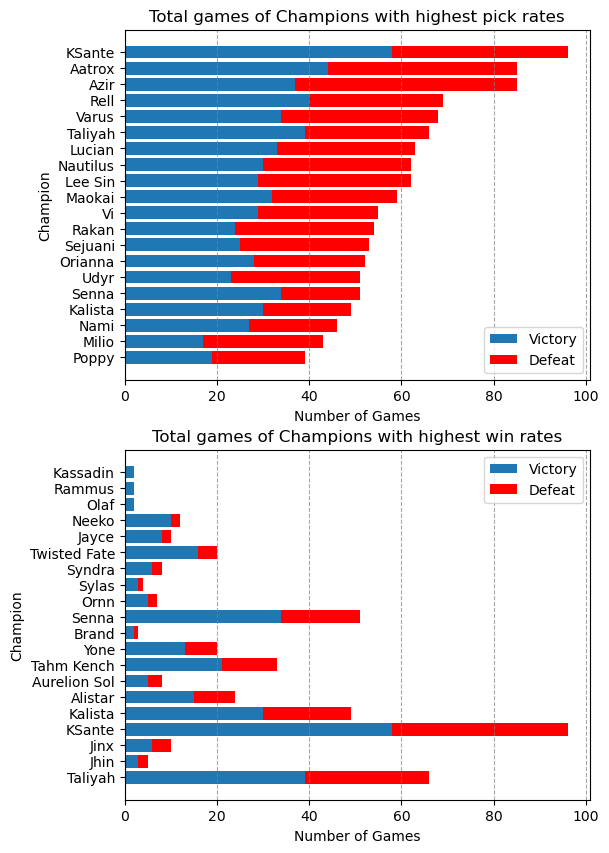

In [93]:
num_rows=20
num_games=len(df)/10
Championdata['pick_rate']=Championdata['total_games']/num_games*100
Championdata_win=Championdata[['Champion','wins','total_games','win_rate']]
Championdata_pick=Championdata[['Champion','wins','total_games','pick_rate']]
Championdata_win = Championdata_win.sort_values('win_rate',ascending=False).head(num_rows)
Championdata_win= Championdata_win.sort_values('win_rate',ascending=True)

Championdata_pick= Championdata_pick.sort_values('pick_rate',ascending=False).head(num_rows)
Championdata_pick= Championdata_pick.sort_values('pick_rate',ascending=True)



fig3, ax3 = plt.subplots(2,figsize=(6,10))
ax3[0].grid(axis='x', linestyle='--', color='gray', alpha=0.7)
ax3[0].barh(Championdata_pick['Champion'],Championdata_pick['wins'], label='Victory')
ax3[0].barh(Championdata_pick['Champion'], Championdata_pick['total_games']-Championdata_pick['wins'], left=Championdata_pick['wins'], color='red', label='Defeat')
ax3[0].legend()

ax3[0].set_xlabel('Number of Games')
ax3[0].set_ylabel('Champion')
ax3[0].set_title('Total games of Champions with highest pick rates')
#ax3[0].invert_yticks()
#ax3[0].set_xticklabels(fig1_data['Player'],rotation=60)

ax3[1].barh(Championdata_win['Champion'],Championdata_win['wins'], label='Victory')
ax3[1].barh(Championdata_win['Champion'], Championdata_win['total_games']-Championdata_win['wins'], left=Championdata_win['wins'], color='red', label='Defeat')
ax3[1].legend()
ax3[1].grid(axis='x', linestyle='--', color='gray', alpha=0.7)
ax3[1].set_xlabel('Number of Games')
ax3[1].set_ylabel('Champion')
ax3[1].set_title('Total games of Champions with highest win rates')
plt.show()

Here, the top figure shows the top 20 champions in terms of pick rate, showing KSante to be the most picked champion. Ksante was used 96 out of 210 games throughout the tournament. Meanwhile, the bottom figure shows the top 20 Champions in terms of win rate. As seen from the figure, most of the champions here have a low pick rate and are most likely used as a counterpick, explaining how they have a high win rate. Out of the twenty champions, only 8 were used at least 20 times and only 4 were used at least 40 times. Out of all the champions, only Senna, Kalista, KSante, and Taliyah shows up in both figure. However, any of these two figures cannot tell us about which champions are most meta relevant because we do not have data on banned champions.

## Game length

In [94]:
"""print(df['Game_length_secs'].median())
fig4, ax4 = plt.subplots()
bins=np.linspace(20,60,21)
ax4.hist(df['Game_length_secs']/60,bins=bins,weights = np.ones(len(df))/10)
ax4.hist(df['Game_length_secs']/60,bins=bins,weights = np.ones(len(df))/10, histtype='step', color='black')
ax4.grid(axis='both', linestyle='--', color='gray', alpha=0.7)
ax4.set_xlabel("Game length (mins)")
ax4.set_ylabel('Number of games')
ax4.set_title("Game Length Distribution of LCK Spring Split 2024")
#ax4.set_yticks(np.linspace(0,80,9))
plt.show()"""

'print(df[\'Game_length_secs\'].median())\nfig4, ax4 = plt.subplots()\nbins=np.linspace(20,60,21)\nax4.hist(df[\'Game_length_secs\']/60,bins=bins,weights = np.ones(len(df))/10)\nax4.hist(df[\'Game_length_secs\']/60,bins=bins,weights = np.ones(len(df))/10, histtype=\'step\', color=\'black\')\nax4.grid(axis=\'both\', linestyle=\'--\', color=\'gray\', alpha=0.7)\nax4.set_xlabel("Game length (mins)")\nax4.set_ylabel(\'Number of games\')\nax4.set_title("Game Length Distribution of LCK Spring Split 2024")\n#ax4.set_yticks(np.linspace(0,80,9))\nplt.show()'

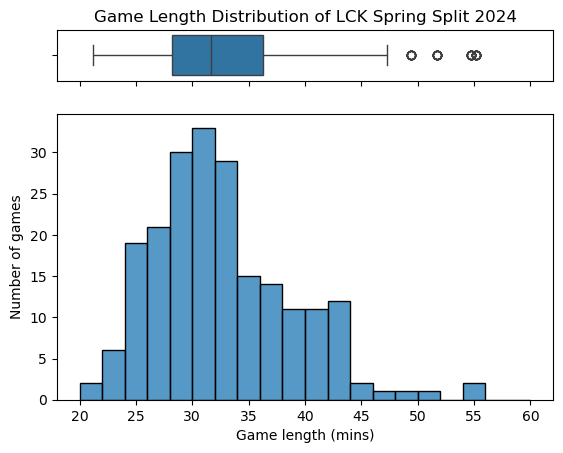

In [95]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
df['Game_length_mins']=df['Game_length_secs']/60 
# assigning a graph to each ax
sns.boxplot(df["Game_length_mins"], orient="h", ax=ax_box)
sns.histplot(data=df, x="Game_length_mins",binwidth=2, bins=20, binrange=[20,60],weights = np.ones(len(df))/10, ax=ax_hist)
ax_hist.set_xlabel("Game length (mins)")
ax_hist.set_ylabel('Number of games')
ax_box.set_title("Game Length Distribution of LCK Spring Split 2024")
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

In this section, the plots show the distribution of game lengths in throughout the tournament. The shortest game lasted until 21:11 which was a game between KT Rolster vs T1. Meanwhile, the longest game, HLE vs KT Rolster, lasted until 55:09. The median game length was computed to be 31:39 while the interquartile range was computed to be from 28:14 to 36:23, telling us that the middle 50% of the games occur within that timestamp.